# Kaggle: Titanic Survival Challenge

In this project, we'll work on developing a workflow to tackle [Kaggle's Titanic survival prediction challenge](https://www.kaggle.com/c/titanic/overview); building a cycle of data processing, feature engineering & selection, algorithm/model evaluation, and file creation/submission that we can re-use as we iterate towards improved prediction accuracy.

In [1]:
import pandas as pd
train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")
holdout.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

## Data Preprocessing

We'll import and apply a few functions, to process our data, that we developed prior to building this project.

In [2]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [3]:
def apply_processing(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    df = create_dummies(df, "Age_categories")
    df = create_dummies(df, "Fare_categories")
    df = create_dummies(df, "Title")
    df = create_dummies(df, "Cabin_type")
    df = create_dummies(df, "Sex")
    
    return df

train = apply_processing(train)
holdout = apply_processing(holdout)

## Exploring the Data

We're going to examine the two columns that contain information about the family members each passenger had onboard: `SibSp` and `Parch`.

In [4]:
relatives = train[["SibSp", "Parch"]]
relatives.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 2 columns):
SibSp    891 non-null int64
Parch    891 non-null int64
dtypes: int64(2)
memory usage: 14.0 KB


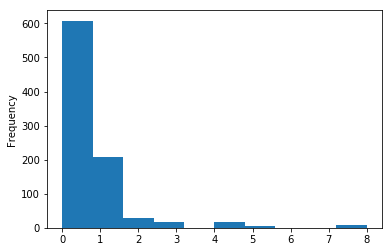

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

train["SibSp"].plot.hist()

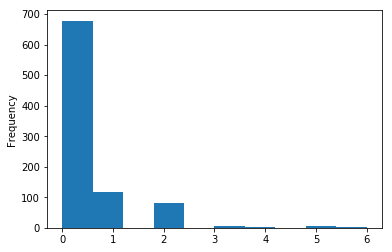

In [6]:
train["Parch"].plot.hist()

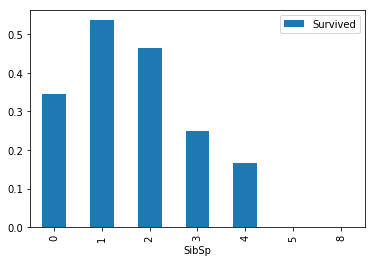

In [7]:
train.pivot_table(index="SibSp", values="Survived").plot.bar()

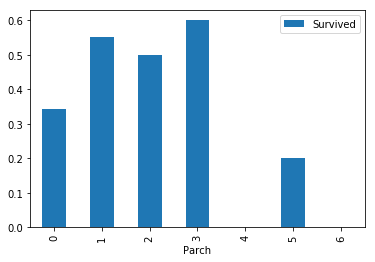

In [8]:
train.pivot_table(index="Parch", values="Survived").plot.bar()

Let's also explore combining these two columns into one `total_relatives` column.

In [9]:
def total_family(df):
    df["total_family"] = df["SibSp"] + df["Parch"]
    return df

train = total_family(train)
holdout = total_family(holdout)

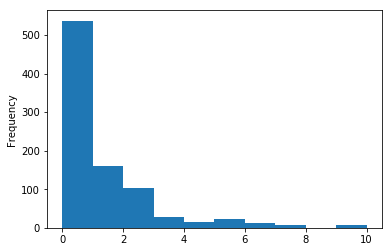

In [10]:
train["total_family"].plot.hist()

In [11]:
family_survival_rate = train.pivot_table(index="total_family", values="Survived")
family_survival_rate

Survived
total_family          
0             0.303538
1             0.552795
2             0.578431
3             0.724138
4             0.200000
5             0.136364
6             0.333333
7             0.000000
10            0.000000

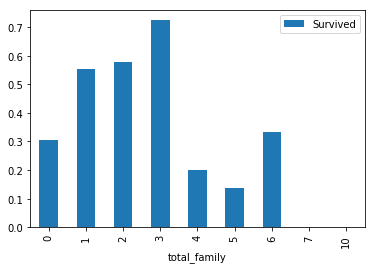

In [12]:
family_survival_rate.plot.bar()

The `SibSp` column shows how many siblings and/or spouses each passenger had onboard, while the `Parch` indicates how manya parents and/or children a passenger had onboard.  Neither column has any missing values.  The distribution in both is skewed right, with a majority of values being 0.

Summing these two columns provides a value representing total family members onboard for each passenger.  The shape of this distribution is similar (see the `total_family` histogram above), though there are fewer values at 0 relative to the rest of the distribution.

Taking a look at the survival rates of the combined family members, we can see that a low percentage of passengers with no family members survived, while greater numbers of passengers with family members did survive.

## Engineering New Features

Based on our finding above, we can create a new feature representative of whether a passenger was alone or not (essentially, a binary column of whether they had any family on board or not).

In [23]:
def process_isalone(df):
    df["is_alone"] = 0
    df.loc[(df["total_family"] == 0), "is_alone"] = 1
    df = df.drop("total_family", axis=1) # drop total_family column, as it is now providing redundant information
    return df

train = process_isalone(train)
holdout = process_isalone(holdout)

In [24]:
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare  ... Cabin_type_C Cabin_type_D  \
0      0         A/5 21171   7.2500  ...            0            0   
1      0          PC 17599  71.2833  ...            1            0   
2      0  STON/O2. 3101282   7.9250  ...            0            0   
3      0            113803  53.1000  ...            1            0   
4      0            373450   8.0500  ...            0            0   

  Cabin_type_E Cabin_type_F Cabin_type_G  Cabin_type_T  Cabin_type_Unknown  \
0            0            0            0             0                   1   
1            0            0            0             0                   0   
2            0            0            0             0                   1   
3            0            0            0             0                   0   
4            0            0            0             0                   1   

   Sex_female  Sex_male  is_alone  
0           0         1         0  
1           1         0         0  
2           1         0         1  
3           1         0         0  
4           0         1         1  

[5 rows x 44 columns]

## Selecting the Best-Performing Features

We'll now create a function that performs data preparation and uses a recursive feature elimination approach (and a random forest algorithm) to find the best-performing set of features from our training dataset.

In [32]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

def select_features(df):
    df_no_null = df.dropna(axis=1)
    df_numeric = df_no_null.select_dtypes(include=["number"])
    all_X = df_numeric.drop(["PassengerId", "Survived"], axis=1)
    all_y = df_numeric["Survived"]
    
    rf = RandomForestClassifier(random_state = 1, n_estimators = 10)
    selector = RFECV(rf, cv = 10)
    selector.fit(all_X, all_y)
    best_features = list(all_X.columns[selector.support_])
    print("Best Features:", "\n----------\n", best_features)
    return best_features

features = select_features(train)

Best Features: 
----------
 ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Young Adult', 'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'is_alone']


## Selecting and Tuning Different Algorithms

Now we'll build a function to run through a few different algorithms, applying grid search to find the best set of hyperparameters for each, and providing us the accuracy results.

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def select_model(df, cols):
    all_X = df[cols]
    all_y = df["Survived"]
    
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters": {
                "solver": ["newton-cg", "lbfgs", "liblinear"]
            }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters": {
                "n_neighbors": range(1, 20, 2),
                "weights": ["distance", "uniform"],
                "algorithm": ["ball_tree", "kd_tree", "brute"],
                "p": [1, 2]
            }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(),
            "hyperparameters": {
                "n_estimators": [4, 6, 9],
                "criterion": ["entropy", "gini"],
                "max_depth": [2, 5, 10], 
                "max_features": ["log2", "sqrt"],
                "min_samples_leaf": [1, 5, 8],
                "min_samples_split": [2, 3, 5]
            }
        }
    ]
    
    for model in models:
        print(model["name"])
        clf = GridSearchCV(model["estimator"], model["hyperparameters"], cv = 10)
        clf.fit(all_X, all_y)
        model["best_params"] = clf.best_params_
        model["best_score"] = clf.best_score_
        model["best_estimator"] = clf.best_estimator_
        print(model["best_params"])
        print(model["best_score"])
        
    return models

trained_models = select_model(train, features)

LogisticRegression


C:\Users\James\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\James\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\James\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\James\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\James\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

{'solver': 'liblinear'}
0.8204264870931538
KNeighborsClassifier


C:\Users\James\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'algorithm': 'brute', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
0.7755331088664422
RandomForestClassifier
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 4}
0.8372615039281706


## Making a Kaggle Submission

For the sake of making our workflow and cycle of data exploration, feature engineering & selection, model testing, and submission easier; we'll build a function to automate the creation of files for submission.

In [36]:
def save_submission_file(fit_model, cols, filename = "submission.csv"):
    predictions = fit_model.predict(holdout[cols])
    submission = pd.DataFrame({"PassengerId": holdout["PassengerId"], "Survived": predictions})
    submission.to_csv(filename, index = False)
    
best_model = trained_models[2]["best_estimator"]

save_submission_file(best_model, features)